# Chapter 4: Generative Adversarial Networks

## WGAN-GP

In this notebook we will be investigating an extension of the WGAN known as the _Wasserstein GAN-Gradient Penalty_ (WGAN-GP). The generator in this model is exactly the same as in the WGAN model, and we make the following changes to the critic:

- We include a _gradient penalty_ term in the critic loss function.

- We do not clip weights of the critic.

- We do not use batch normalization on the layers in the critic.

### Gradient Penalty Loss

The gradient penalty loss measures the mean squared norm of gradient of predictions with respect to input images and 1. Since it is intractable to take the gradient with respect to each input image, we only take the gradient with respect to a handful of points which are interpolated from real and fake images. The interpolation algorithm works as follows:

1. We randomly select a batch of real and fake images, $X_\text{real}$ and $X_\text{fake}$ respectively, both of size $m$.

2. We compute a $m$-dimensional vector $\alpha$ whose elements are random numbers in the range [0, 1].

3. For each $x_\text{real}^i\in X_\text{real}$ and $x_\text{fake}^i \in X_\text{fake}$ we compute

  $$\hat{x}_i = \alpha_i x_\text{real}^i + (1 - \alpha_i) x_\text{fake}^i $$

  where $i \in \{1,...,m\}$. In other words, each $\hat{x}_i$ is a randomly weighted interpolation between a real image, $x_\text{real}^i$, and a fake image, $x_\text{fake}^i$.

4. For each resulting $\hat{x}_i$, we compute $\left\lVert\nabla D\left(\hat{x}_i\right)\right\rVert$ or the L2 norm (i.e. the Euclidean norm) of the gradient of the critic at each $\hat{x}_i$.

5. We then compute the term for the loss function given by

  $$ \mathbb{E}_{\hat{x}_i} \big( 1 - \left\lVert\nabla D\left(\hat{x}_i\right)\right\rVert \big)^2 $$

  i.e. the mean of the difference of the L2 norm of the gradient of $D$ at $\hat{x}_i$ and 1 squared.

Another difference between the WGAN-GP and the standard WGAN is that while training the latter's critic, we freeze the weights of the generator. This is so that the generator's gradients do not contribute to the gradient penalty loss term.

## Implementing a WGAN-GP

Below is an example implementation of a WGAN-GP that will be used to generate images that appear to be sampled from the CelebA dataset.

In [0]:
!pip install -U tensorflow-gpu

In [0]:
# Mount Google drive to load the data and to save the model weights.
from google.colab import drive

drive.mount('/content/gdrive/')
checkpoint_path = '/content/gdrive/My Drive/gdl_models/wgan-gp/'

In [0]:
%tensorflow_version 1.x
from tensorflow.keras.layers import (Input, Conv2D, LeakyReLU, Activation,
                                     Dropout, Flatten, Dense, Reshape,
                                     BatchNormalization, UpSampling2D,
                                     Conv2DTranspose, Lambda)
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
import numpy as np
import tensorflow.keras.backend as K
from functools import partial
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)


def get_activation(activation_fn_name):
  """Get the activation layer from the name of the function."""
  if activation_fn_name == 'leaky_relu':
    return LeakyReLU(alpha=0.2)
  return Activation(activation_fn_name)


def set_trainable(model, value):
  """Set each layer of a model as trainable."""
  model.trainable = value
  for l in model.layers:
    l.trainable = value


def get_optimizer(optimizer_name, learning_rate):
  """Get an optimizer by name."""
  if optimizer_name == 'adam':
    return Adam(lr=learning_rate)
  if optimizer_name == 'rmsprop':
    return RMSprop(lr=learning_rate)
  return Adam(lr=learning_rate)


def wasserstein_loss(y_true, y_pred):
  """Wasserstein loss function."""
  return -K.mean(y_true * y_pred)


class WGANGP(object):
  """Implementation of a WGAN-GP using Keras."""

  def __init__(self, input_shape, critic_conv_filters, critic_conv_kernel_size,
               critic_conv_strides, critic_activation, critic_dropout_rate,
               critic_learning_rate, generator_initial_dense_layer_shape,
               generator_upsample, generator_conv_filters,
               generator_conv_kernel_size, generator_conv_strides,
               generator_batch_norm_momentum, generator_activation,
               generator_dropout_rate, generator_learning_rate, optimizer,
               gradient_weight, z_dim, batch_size):
    # Build the critic.
    critic_input = Input(shape=input_shape, name='critic_input')
    x = critic_input
    weight_init = RandomNormal(mean=0.0, stddev=0.02)
    for i in range(len(critic_conv_filters)):
      x = Conv2D(filters=critic_conv_filters[i],
                 kernel_size=critic_conv_kernel_size[i],
                 strides=critic_conv_strides[i], padding='same',
                 kernel_initializer=weight_init,
                 name='critic_conv_{}'.format(i))(x)
      x = get_activation(critic_activation)(x)
      if critic_dropout_rate:
        x = Dropout(rate=critic_dropout_rate)(x)
    x = Flatten()(x)
    critic_output = Dense(1, activation=None, kernel_initializer=weight_init)(x)
    self.critic = Model(critic_input, critic_output)

    self.z_dim = z_dim

    # Build the generator.
    generator_input = Input(shape=(z_dim,), name='generator_input')
    x = generator_input
    x = Dense(np.prod(generator_initial_dense_layer_shape),
              kernel_initializer=weight_init)(x)
    if generator_batch_norm_momentum:
      x = BatchNormalization(momentum=generator_batch_norm_momentum)(x)
    x = get_activation(generator_activation)(x)
    x = Reshape(target_shape=generator_initial_dense_layer_shape)(x)
    if generator_dropout_rate:
      x = Dropout(rate=generator_dropout_rate)(x)
    for i in range(len(generator_upsample)):
      if generator_upsample == 2:
        x = UpSampling2D()(x)
        x = Conv2D(filters=generator_conv_filters[i],
                   kernel_size=generator_conv_kernel_size[i],
                   strides=generator_conv_strides[i], padding='same',
                   kernel_initializer=weight_init,
                   name='generator_conv_{}'.format(i))(x)
      else:
        x = Conv2DTranspose(filters=generator_conv_filters[i],
                            kernel_size=generator_conv_kernel_size[i],
                            strides=generator_conv_strides[i], padding='same',
                            kernel_initializer=weight_init,
                            name='generator_conv_{}'.format(i))(x)
      if i == (len(generator_upsample) - 1):
        break
      if generator_batch_norm_momentum:
        x = BatchNormalization(momentum=generator_batch_norm_momentum)(x)
      x = get_activation(generator_activation)(x)
    generator_output = Activation('tanh')(x)
    self.generator = Model(generator_input, generator_output)

    # Compile the critic.
    set_trainable(self.generator, False)

    real_img = Input(shape=input_shape)
    z_disc = Input(shape=(z_dim,))
    fake_img = self.generator(z_disc)

    real = self.critic(real_img)
    fake = self.critic(fake_img)

    def interpolate_inputs(inputs):
      alpha = K.random_uniform((batch_size, 1, 1, 1))
      return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

    self.interpolated_img = Lambda(interpolate_inputs)([real_img, fake_img])
    interpolated_prediction = self.critic(self.interpolated_img)

    self.critic_model = Model(inputs=[real_img, z_disc],
                              outputs=[real, fake, interpolated_prediction])

    self.critic_model.compile(
        loss=[wasserstein_loss, wasserstein_loss, self.gradient_penalty_loss],
        optimizer=get_optimizer(optimizer, critic_learning_rate),
        loss_weights=[1, 1, gradient_weight])

    set_trainable(self.generator, True)

    # Compile the generator.
    set_trainable(self.critic, False)

    model_input = Input(shape=(z_dim,))
    model_output = self.critic(self.generator(model_input))
    self.model = Model(model_input, model_output)
    self.model.compile(
        loss=wasserstein_loss,
        optimizer=get_optimizer(optimizer, generator_learning_rate))

  def gradient_penalty_loss(self, y_true, y_pred):
    """Compute the GP loss using interpolations of real and fake images."""
    gradients = K.gradients(y_pred, self.interpolated_img)[0]
    assert gradients is not None
    gradients_sqr = K.square(gradients)
    gradients_l2_norm = K.sqrt(
        K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape))))
    return K.mean(K.square(1 - gradients_l2_norm))

  def train_critic(self, X_train, batch_size):
    """Train the critic."""
    real = np.ones((batch_size, 1), dtype=np.float32)
    fake = -np.ones((batch_size, 1), dtype=np.float32)
    dummy = np.zeros((batch_size, 1), dtype=np.float32)
    X_real, _ = next(X_train)
    while X_real.shape[0] != batch_size:
      X_real, _ = next(X_train)
    noise = np.random.normal(0.0, 1.0, (batch_size, self.z_dim))
    return self.critic_model.train_on_batch([X_real, noise],
                                            [real, fake, dummy])
    
  def train_generator(self, batch_size):
    """Train the generator model."""
    real = np.ones((batch_size, 1), dtype=np.float32)
    noise = np.random.normal(0, 1, (batch_size, self.z_dim))
    return self.model.train_on_batch(noise, real)

  def train(self, X_train, batch_size, epochs, n_critic, print_every_n_epochs,
            checkpoint_path, save_every_n_epochs, initial_epoch):
    """Train the WGAN-GP model using a data generator."""
    if checkpoint_path and initial_epoch > 0:
      self.model.load_weights(
          checkpoint_path + 'model_weights_{}.hdf5'.format(initial_epoch))
    for epoch in range(initial_epoch + 1, epochs + 1):
      for _ in range(n_critic):
        d_loss = self.train_critic(X_train, batch_size)
      g_loss = self.train_generator(batch_size)
      if epoch % print_every_n_epochs == 0:
        print('Epoch: {}'.format(epoch))
        print('D Loss: {:04f}'.format(d_loss[0]))
        print('G Loss: {:04f}'.format(g_loss))
      if epoch % save_every_n_epochs == 0 and checkpoint_path:
        print('Saving after epoch: {}'.format(epoch))
        self.model.save_weights(checkpoint_path + 'model_weights.hdf5')
        self.model.save_weights(
            checkpoint_path + 'model_weights_{}.hdf5'.format(epoch))

In [0]:
IMAGE_SIZE = 64
BATCH_SIZE = 64

wgangp = WGANGP(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                critic_conv_filters=(64, 128, 256, 512),
                critic_conv_kernel_size=(5, 5, 5, 5),
                critic_conv_strides=(2, 2, 2, 2),
                critic_activation='leaky_relu',
                critic_dropout_rate=None,
                critic_learning_rate=0.0002,
                generator_initial_dense_layer_shape=(4, 4, 64),
                generator_upsample=(1, 1, 1, 1),
                generator_conv_filters=(256, 128, 64, 3),
                generator_conv_kernel_size=(5, 5, 5, 5),
                generator_conv_strides=(2, 2, 2, 2),
                generator_batch_norm_momentum=0.9,
                generator_activation='leaky_relu',
                generator_dropout_rate=None,
                generator_learning_rate=0.0002,
                optimizer='adam',
                gradient_weight=10,
                z_dim=100,
                batch_size=BATCH_SIZE)

In [92]:
wgangp.critic.summary()

Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 64, 64, 3)]       0         
_________________________________________________________________
critic_conv_0 (Conv2D)       multiple                  4864      
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   multiple                  0         
_________________________________________________________________
critic_conv_1 (Conv2D)       multiple                  204928    
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   multiple                  0         
_________________________________________________________________
critic_conv_2 (Conv2D)       multiple                  819456    
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   multiple                  0  

In [93]:
wgangp.generator.summary()

Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_48 (Batc (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 4, 4, 64)          0         
_________________________________________________________________
generator_conv_0 (Conv2DTran (None, 8, 8, 256)         409856    
_________________________________________________________________
batch_normalization_49 (Batc (None, 8, 8, 256)         102

## Downloading the Data

Now we will download the CelebA dataset. Since this dataset is large, we need to create a data generator to load images from disk.

In [0]:
!mkdir data && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

In [0]:
import zipfile

with zipfile.ZipFile('celeba.zip', 'r') as z:
  z.extractall('data/')

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1.0/255.0)
data_flow_train = data_gen.flow_from_directory(
    'data', target_size=[IMAGE_SIZE, IMAGE_SIZE], batch_size=BATCH_SIZE,
    shuffle=True, class_mode='input', subset='training')

Found 202599 images belonging to 1 classes.


## Training the WGAN-GP

Below we train the model with 10,000 training epochs. Below we compare images from the test set with images the generator makes from noise.

In [0]:
wgangp.train(data_flow_train, batch_size=BATCH_SIZE, epochs=10000, n_critic=5,
             print_every_n_epochs=10, checkpoint_path=checkpoint_path,
             save_every_n_epochs=100, initial_epoch=0)

## Analyzing the Results

In [42]:
n_to_show = 20

data_flow_analysis = data_gen.flow_from_directory(
    'data', target_size=[IMAGE_SIZE, IMAGE_SIZE], batch_size=n_to_show,
    shuffle=True, class_mode='input', subset='training')

Found 202599 images belonging to 1 classes.


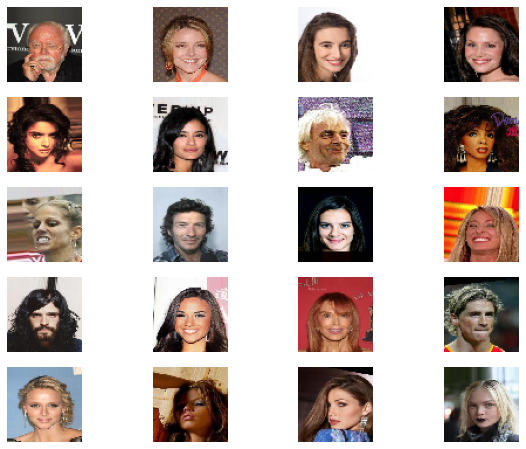

In [112]:
import matplotlib.pyplot as plt

n_rows = 5
X_batch, _ = next(data_flow_analysis)
fig = plt.figure(figsize=(10, 8))

for i, x in enumerate(X_batch):
  ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
  ax.axis('off')
  ax.imshow(x.squeeze(), interpolation='antialiased')

At 2,000 epochs into training, we see that the model has learned the basic structure of the human face, but struggles to create clear pictures.

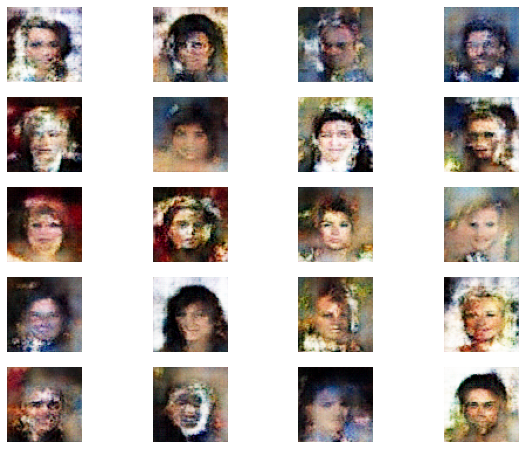

In [107]:
# 2200

wgangp.model.load_weights(
    checkpoint_path + 'model_weights_{}.hdf5'.format(2200))

fig = plt.figure(figsize=(10, 8))

for i in range(n_to_show):
  x = wgangp.generator.predict(
      np.random.normal(0.0, 1.0, size=(1, wgangp.z_dim)))[0]
  x = np.clip(x, 0, 1)
  ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
  ax.axis('off')
  ax.imshow(x.squeeze(), interpolation='antialiased')

At 5,000 epochs, we see a significant improvement in the model's ability to generate clearer images.

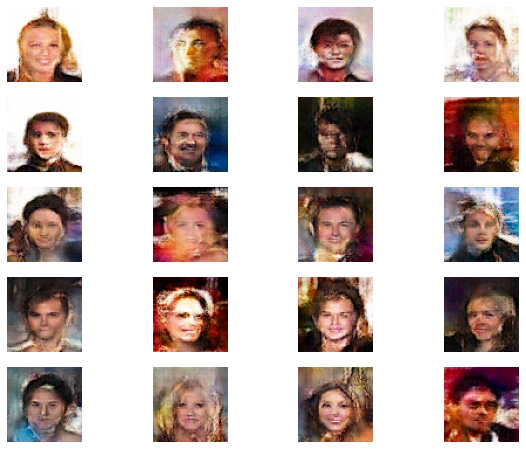

In [108]:
# 5000

wgangp.model.load_weights(
    checkpoint_path + 'model_weights_{}.hdf5'.format(5000))

fig = plt.figure(figsize=(10, 8))

for i in range(n_to_show):
  x = wgangp.generator.predict(
      np.random.normal(0.0, 1.0, size=(1, wgangp.z_dim)))[0]
  x = np.clip(x, 0, 1)
  ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
  ax.axis('off')
  ax.imshow(x.squeeze(), interpolation='antialiased')

At 8,000 training epochs in, the model is starting to be able to create more realistic looking faces. There is still some evidence that the images are generated, but you can easily tell the pictures are of a human face.

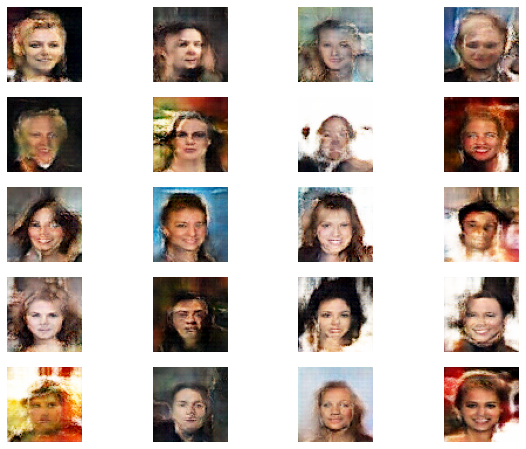

In [109]:
# 8000

wgangp.model.load_weights(
    checkpoint_path + 'model_weights_{}.hdf5'.format(8000))

fig = plt.figure(figsize=(10, 8))

for i in range(n_to_show):
  x = wgangp.generator.predict(
      np.random.normal(0.0, 1.0, size=(1, wgangp.z_dim)))[0]
  x = np.clip(x, 0, 1)
  ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
  ax.axis('off')
  ax.imshow(x.squeeze(), interpolation='antialiased')

The model shows slight improvement from 8,000 to 10,000 training epochs. The model could be further improved with more training, using deeper convolutional networks to analyze the images, and finer tuning of hyperparameters.

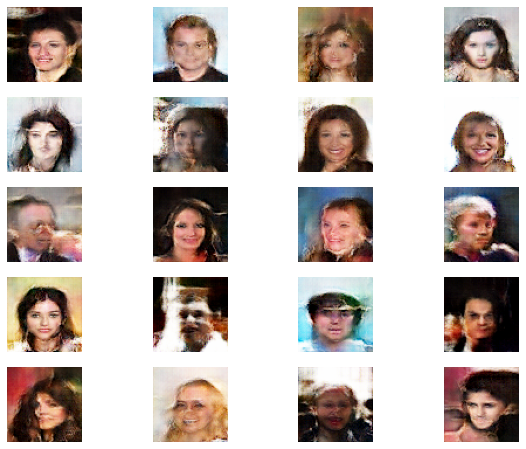

In [110]:
# 10000

wgangp.model.load_weights(
    checkpoint_path + 'model_weights_{}.hdf5'.format(10000))

fig = plt.figure(figsize=(10, 8))

for i in range(n_to_show):
  x = wgangp.generator.predict(
      np.random.normal(0.0, 1.0, size=(1, wgangp.z_dim)))[0]
  x = np.clip(x, 0, 1)
  ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
  ax.axis('off')
  ax.imshow(x.squeeze(), interpolation='antialiased')